## 0.Preliminaries


In generative modeling one is opting to learn probability distribution, which best approximates (in some sense) probability distribution (manifold) of observed data. This enables sampling new data and obtaining probability for any sample, which can help with identifying whether given data sample was drawn from original distribution or not (e.g fake or real). 
One important observation is that of instead of learning true probability of data distribution directly, we learn so called (Stein) score function: 
\begin{equation}
    s(x) = \nabla _x \log p(x)
\end{equation}

Why do we care? Simple answer is that we do not need to compute normalizing constant (to make it proper probability distribution, somewhat restriction). Other reasons:
 - Conditional generation: $\nabla _x p(x | y) = \nabla _x (\frac{p(x, y) p(x)}{p(y)})$
 - Inpainting

## 1. SDEs


Basic diffusion process on real line can be viewed as:
\begin{equation}
    \dot{x} = \sigma \eta(t)
\end{equation}
where $\sigma > 0$ and $\eta(t)$ is gaussian noise.

By using Euler-Maryama discretization $x(t + \delta t) = x(t) + \sigma \sqrt{\delta t} r$, $r \sim \mathcal{N(0, 1)}$. In this way we can obtain trajectory of some sample $x$. However, more interesting is how probability density varies through time. This dynamics is governed by following ODE:
\begin{equation}
    \frac{\partial p(x, t)}{\partial t} = const \cdot \frac{\partial^2 p(x, t)}{\partial x^2}
\end{equation}
It is known that solution given initial distribution $p(x, 0)$ is given by:
$$p(x, t | x_0, 0) = \frac{1}{\sqrt{2 \pi \sigma^2 t}} \exp\left\{ - \frac{(x - x_0)^2}{2 \sigma^2 t}  \right\} \ . $$
Thus, general solution at any time $t$: 
$$p(x, t) = \int _{\mathbb{R}}p(x, t| x_0, 0)p_0 (x_0) dx_0$$

In general, (Ito) SDE has the following form: $$\dot{x} = f(x, t) + \eta (t) g(x, t)$$ (also 1 dimensional)
Analagous to 1-dim case above, the pdf at each timestep is given by Fokker-Planck equation:
$$\frac{\partial p(x, t)}{\partial t} = - \frac{\partial}{\partial x} \left[ \  f(x, t) p(x, t) \ \right] + \frac{\partial^2}{\partial x^2} \left[ \ \frac{g(x, t)^2}{2} p(x, t) \ \right] \ .$$
However, those equations are hard to solve, so we can review only particular cases of SDEs, such as Ornstein-Uhlenbech processes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

In [42]:
import typing as tp

def forward_sde(initial_pos: np.array, steps: int, dt: float, f: tp.Callable[[np.array, float], np.ndarray], 
                g: tp.Callable[[np.array, np.ndarray], np.ndarray], params: dict) -> np.ndarray:
    
    t = 0
    trajectory = np.zeros((steps + 1, *initial_pos.shape)) # each row - time step, each column - each sample
    trajectory[0] = np.copy(initial_pos)
    
    for i in range(steps):
        random_normal = np.random.randn(*initial_pos.shape)
        trajectory[i + 1] = trajectory[i] + f(trajectory[i], t) * dt + g(trajectory[i], t, params) * np.sqrt(dt) * random_normal
        t += dt
    return trajectory

def f(x, t):
    return np.zeros((*x.shape, ))
def g(x, t, params):
    return params['sigma'] * np.ones((*x.shape, ))

def transition_probability_diffusion_exact(x, t, params):
    x0, sigma= params['x0'], params['sigma']
    pdf = norm.pdf(x, loc=x0, scale=np.sqrt((sigma**2)*t))
    
    return pdf


In [43]:
sigma = 1 
num_samples = 1000
x0 = np.zeros(num_samples)

nsteps = 2000
dt = 0.001
T = nsteps*dt
t = np.linspace(0, T, nsteps + 1)


params = {'sigma': sigma, 'x0':x0, 'T':T}

In [44]:
x_traj = forward_sde(x0, nsteps, dt, f, g, params)

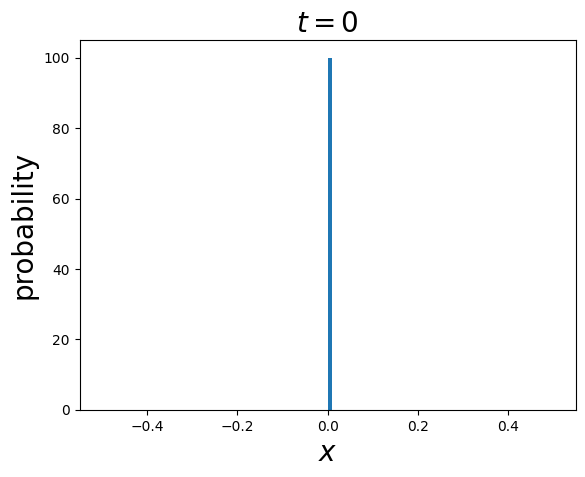

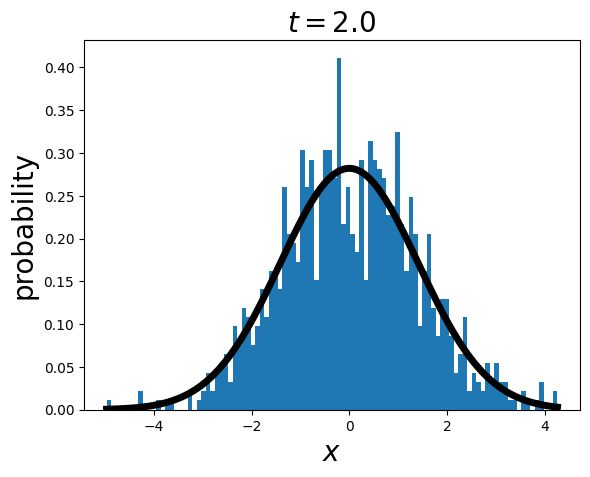

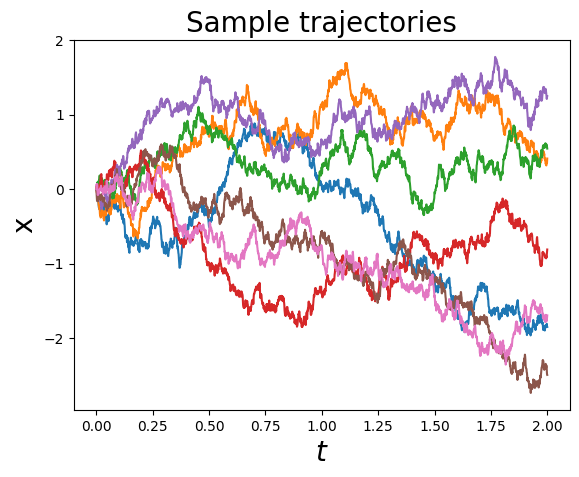

In [50]:
plt.hist(x_traj[0], density=True, bins=100)
plt.title("$t = 0$", fontsize=20)
plt.xlabel("$x$", fontsize=20)
plt.ylabel("probability", fontsize=20)
plt.show()

x_f_min, x_f_max = np.amin(x_traj[-1]), np.amax(x_traj[-1])
num_xf = 1000
x_f_arg = np.linspace(x_f_min, x_f_max, num_xf)
pdf_final = transition_probability_diffusion_exact(x_f_arg, T, params)


# Plot final distribution (distribution after diffusion)
plt.hist(x_traj[-1], bins=100, density=True)
plt.plot(x_f_arg, pdf_final, color='black', linewidth=5)
plt.title("$t = $"+str(T), fontsize=20)
plt.xlabel("$x$", fontsize=20)
plt.ylabel("probability", fontsize=20)
plt.show()


# Plot some trajectories
sample_trajectories = [50, 1, 2, 3, 999, 15, 20]
for s in sample_trajectories:
    plt.plot(t, x_traj[:, s])
plt.title("Sample trajectories", fontsize=20)
plt.xlabel("$t$", fontsize=20)
plt.ylabel("x", fontsize=20)
plt.show()

2.0